# Support Vector Machine: 2D Binary Classification

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from scipy.optimize import minimize

## Generate 2D Toy Data Set

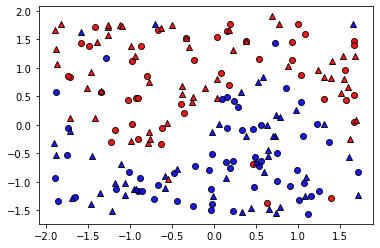

In [2]:
np.random.seed(0)

N = 200
x = 2 * (np.random.rand(N,2) - 0.5)

# XOR function
#y = (x[:,0] > 0)^(x[:,1] > 0)

# Checkboard
#y = (np.mod(np.round(x[:,0]*2),2) == 0)^(np.mod(np.round(x[:,1]*2),2) == 0)

# Circle
#y = (x[:,0] ** 2 + x[:,1] ** 2 > 0.25)

# Sine function
y = (x[:,1] > 0.5*np.sin(4*x[:,0]))

# Add noise in the label
for i in range(round(N*0.1)):
    y[np.random.randint(0,N-1)] = 1 - y[np.random.randint(0,N-1)]

def plot2Ddata(X_train,X_test,y_train,y_test):
    plt.scatter(X_train[y_train == 0,0],X_train[y_train == 0,1],
                color='b',marker='o',alpha=0.9,edgecolors='k')
    plt.scatter(X_train[y_train == 1,0],X_train[y_train == 1,1],
                color='r',marker='o',alpha=0.9,edgecolors='k')
    plt.scatter(X_test[y_test == 0,0],X_test[y_test == 0,1],
                color='b',marker='^',alpha=0.9,edgecolors='k')
    plt.scatter(X_test[y_test == 1,0],X_test[y_test == 1,1],
                color='r',marker='^',alpha=0.9,edgecolors='k')

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

plot2Ddata(X_train,X_test,y_train,y_test)

## Create Soft Margin SVM Class

In [3]:
class SoftMarginSVC:
    def __init__(self, C=1000, gamma=1):
        self.C = C           # Box constraint
        self.gamma = gamma   # RBF kernel scale
        self.X = None  # Training set X
        self.y = None  # Training set y
        self.b = 0     # Bias

    def kernel_func(self, x1, x2):
        return np.exp(-self.gamma * pairwise_distances(x1, x2, metric='sqeuclidean'))
        
    def fit(self, X, y):
        self.X, self.y = X, 2*y-1   # Map y \in [0,1] into [-1,1]
        n_samples = X.shape[0]
        
        # Create kernel (Gram) matrix
        self.K = self.kernel_func(X_train,X_train)

        # Define the objective function for the dual problem
        def objective(alpha):
            # Dual objective
            #return 0.5 * np.sum(np.outer(alpha,alpha) * np.outer(self.y,self.y) * self.K) - np.sum(alpha)
            return 0.5 * np.dot(np.dot(alpha * self.y, self.K), alpha * self.y) - np.sum(alpha)

        # Initial guess for alpha
        #initial_alpha = np.random.rand(1,n_samples)
        initial_alpha = np.zeros(n_samples)
        
        # Define the constraints and bounds
        cons = ({'type': 'eq', 'fun': lambda alpha: np.dot(alpha, self.y)})
        bnds = [(0, self.C) for _ in initial_alpha]

        # Minimize the objective function subject to the constraints
        res = minimize(objective, initial_alpha, constraints=cons, bounds=bnds)
        print(res.message)

        # Extract the optimal alpha values
        alpha = res.x

        # Extract support vectors
        self.sv_indices = alpha > 1e-5
        self.support_vectors = self.X[self.sv_indices,:]
        self.support_labels = self.y[self.sv_indices]
        self.alpha = alpha[self.sv_indices]

        # Calculate the bias
        y_pred = self.predict_proba(self.support_vectors)
        self.b = np.mean(self.support_labels - y_pred)

    def predict(self, X):
        return self.predict_proba(X) > 0
        
    def predict_proba(self, X):
        K = self.kernel_func(self.support_vectors, X)
        return np.dot(self.support_labels * self.alpha, K) + self.b
    
    def plot_decision(self, X, y):
        nx, ny = 100, 100
        xv, yv = np.meshgrid(np.linspace(-3,3,nx), 
                             np.linspace(-3,3,ny))
        zv = np.zeros(xv.shape)
        for i in range(nx):
            for j in range(ny):
                zv[i,j] = self.predict_proba(np.array([xv[i,j], yv[i,j]]).reshape(1,-1))

        plt.figure(figsize=(10,7))
        # Normalize colors so that 0 will match white
        divnorm = colors.TwoSlopeNorm(vmin=np.min(zv), vcenter=0, vmax=np.max(zv))
        con = plt.contourf(xv, yv, zv, cmap=cm.bwr, levels=50, alpha=0.6, norm=divnorm)
        plt.scatter(X[y == 0,0],X[y == 0,1], s=50, color='b', marker='o',
                    alpha=0.9, edgecolors='k', label='(-) Training samples')
        plt.scatter(X[y == 1,0],X[y == 1,1], s=50, color='r', marker='o',
                    alpha=0.9, edgecolors='k', label='(+) Training samples')
        plt.scatter(self.support_vectors[:,0],self.support_vectors[:,1], s=150,
                    marker='*', facecolors="None", edgecolors='k',label='Support Vectors')
        plt.colorbar(con)
        plt.legend()
        plt.show()

## Train the SVM and Evaluate Performance

Optimization terminated successfully
Training accuracy: 0.9
Testing accuracy: 0.91


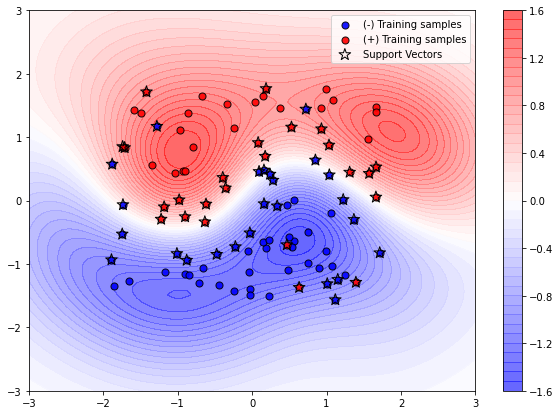

In [4]:
# Train the soft-margin SVC
svc = SoftMarginSVC(C=1,gamma=0.5)
svc.fit(X_train, y_train)

# Make predictions
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

# Evaluate accuracy
train_acc = np.mean(y_train_pred == y_train)
test_acc = np.mean(y_test_pred == y_test)
print("Training accuracy:", train_acc)
print("Testing accuracy:", test_acc)

svc.plot_decision(X_train,y_train)